# Transcription


<!-- 
# Remove chache directory
from datasets.utils.logging import set_verbosity_error
from datasets import config

# Set verbosity to error to suppress logging output
set_verbosity_error()

# Print the cache directory
print(config.HF_DATASETS_CACHE) 
-->


In [1]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from datasets import load_dataset

# load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

# load dummy dataset and read audio files
ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

sample = ds[0]["audio"]

input_features = processor(sample["array"], sampling_rate=sample["sampling_rate"], return_tensors="pt").input_features 

# generate token ids
predicted_ids = model.generate(input_features)

# # decode token ids to text
# transcription = processor.batch_decode(predicted_ids, skip_special_tokens=False)
# transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)

# Decode token ids to text
transcription_with_special_tokens = processor.batch_decode(predicted_ids, skip_special_tokens=False) #  includes special tokens in the transcription
transcription_without_special_tokens = processor.batch_decode(predicted_ids, skip_special_tokens=True) #  does not includes special tokens in the transcription


/home/ajtruyen/.local/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for hf-internal-testing/librispeech_asr_dummy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hf-internal-testing/librispeech_asr_dummy
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
2024-05-08 20:50:14.332809: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 20:50:18.445761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


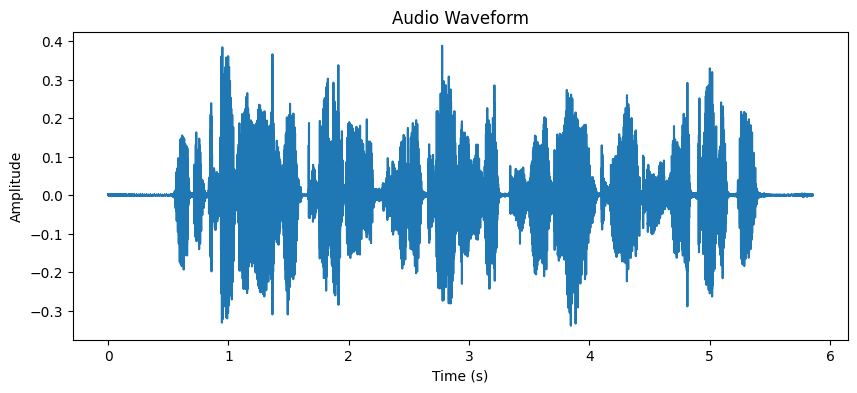

Transcription with special tokens: ['<|startoftranscript|><|notimestamps|> Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel.<|endoftext|>']
Transcription without special tokens: [' Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel.']


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the audio waveform
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, len(sample["array"]) / sample["sampling_rate"], num=len(sample["array"])), sample["array"])
plt.title("Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Print transcriptions
print("Transcription with special tokens:", transcription_with_special_tokens)
print("Transcription without special tokens:", transcription_without_special_tokens)

# Evaluation of the model

In [3]:
from datasets import load_dataset
from transformers import WhisperForConditionalGeneration, WhisperProcessor
import torch
from evaluate import load

librispeech_test_clean = load_dataset("librispeech_asr", "clean", split="test")

processor = WhisperProcessor.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en").to("cuda")

def map_to_pred(batch):
    audio = batch["audio"]
    input_features = processor(audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt").input_features
    batch["reference"] = processor.tokenizer._normalize(batch['text'])

    with torch.no_grad():
        predicted_ids = model.generate(input_features.to("cuda"))[0]
    transcription = processor.decode(predicted_ids)
    batch["prediction"] = processor.tokenizer._normalize(transcription)
    return batch

result = librispeech_test_clean.map(map_to_pred)

wer = load("wer")
print(100 * wer.compute(references=result["reference"], predictions=result["prediction"]))
5.655609406528749

/home/ajtruyen/.local/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for librispeech_asr contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/librispeech_asr
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Map:   0%|          | 0/2620 [00:00<?, ? examples/s]

/home/ajtruyen/.local/lib/python3.10/site-packages/transformers/models/whisper/tokenization_whisper.py:511: UserWarning: The private method `_normalize` is deprecated and will be removed in v5 of Transformers.You can normalize an input string using the Whisper English normalizer using the `normalize` method.
  warnings.warn(


5.655609406528749


5.655609406528749

# Long-Form Transcription

In [4]:
import torch
from transformers import pipeline
from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"

pipe = pipeline(
  "automatic-speech-recognition",
  model="openai/whisper-tiny.en",
  chunk_length_s=30,
  device=device,
)

ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
sample = ds[0]["audio"]

prediction = pipe(sample.copy(), batch_size=8)["text"]
" Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel."

# we can also return timestamps for the predictions
prediction = pipe(sample.copy(), batch_size=8, return_timestamps=True)["chunks"]
[{'text': ' Mr. Quilter is the apostle of the middle classes and we are glad to welcome his gospel.',
  'timestamp': (0.0, 5.44)}]

RuntimeError: Failed to import transformers.models.whisper.modeling_tf_whisper because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.